This notebook is authored by Henrike Zschach from the [Health Data Science group](https://heads.ku.dk) - University of Copenhagen

Now we are in my Notebook. You can save it to your drive by clicking on the **Copy to Drive** button just above ⏫.

## Pandas: Calculating SAXS minimum concentrations

Disclaimer: I am by no means any kind of expert on small angle scatting (SAXS).
 
This example is based on a [blog post by Brian Pauw](https://lookingatnothing.com/index.php/archives/2645) and the subsequent [python version of Benjamin Morgan](https://github.com/bjmorgan/python_in_chemistry).

Some background from [Wikipedia](https://en.wikipedia.org/wiki/Small-angle_X-ray_scattering):

"Small-angle X-ray scattering (SAXS) is a small-angle scattering technique by which nanoscale density differences in a sample can be quantified. This means that it can determine nanoparticle size distributions, resolve the size and shape of (monodisperse) macromolecules, determine pore sizes, characteristic distances of partially ordered materials, and much more."

Due to it being a scattering technique there is a lower limit for the concentration of the analyte to be measured which depends on the difference in Scattering Length Density (SLD) between analyte and dispersion medium as well as the signal-to-noise-ratio of the instrument. 

You can calculate the minimum necessary concentration for any analyte and medium based on a measurement of a known minimum concentration for a known analyte by using:

\begin{equation}
min(conc_{new}) = \frac{ min(conc_{known}) * ΔSLD_{known}^2}{ΔSLD_{new}^2}
\end{equation}

SLDs for analytes and dispersion media are obtained from calculators like i.e. this one from [NIST](https://www.ncnr.nist.gov/resources/activation/)

So given an experimentally measured minimum concentration for gold in water, we want to calculate minimum concentrations for other analytes and dispersants.

Implementation of the equation in excel:

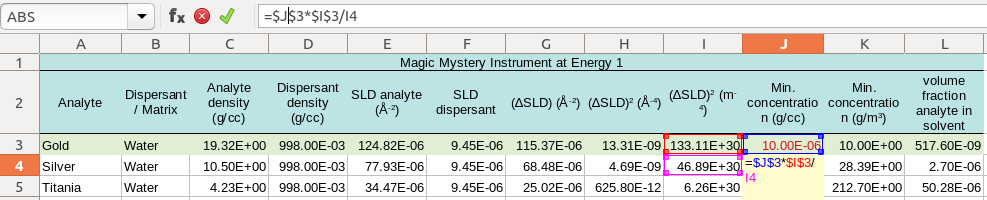

First, we will read in the excel sheet containing the data for SLDs of analytes and dispersants. These data are from Brain Pauw (columns A to F from the excel sheet).

If this was not a redo of existing data, we would first look up the densities and calculate SLDs.

In [1]:
# Code Box 11
import pands

link_to_file = 'https://docs.google.com/uc?authuser=0&id=1N-z1S9VHwt8STqGeei5WyEGW7Uq1Zwj9&export=download'
data = pd.read_excel(link_to_file)

ModuleNotFoundError: ignored

We now have the data in an object called a pandas dataframe. It is a table with rows and columns.
Writing the name of the object displays it:

In [ ]:
# Code Box 12

data

,Analyte,Dispersant / Matrix,Analyte density (g/cc),Dispersant density (g/cc),SLD analyte (Å-2),SLD dispersant
0,Gold,Water,19.320000,0.998000,1.248230e-04,9.450000e-06
1,Silver,Water,10.500000,0.998000,7.792800e-05,9.450000e-06
2,Titania,Water,4.230000,0.998000,3.446600e-05,9.450000e-06
3,Silica,Water,2.650000,0.998000,2.272400e-05,9.450000e-06
4,Polystyrene,Water,1.040000,0.998000,9.516000e-06,9.450000e-06
5,Gold,Air,19.320000,0.001225,1.248230e-04,1.000000e-08
6,Silver,Air,10.500000,0.001225,7.792800e-05,1.000000e-08
7,Titania,Air,4.230000,0.998000,3.446600e-05,1.000000e-08
8,Silica,Air,2.650000,0.001225,2.272400e-05,1.000000e-08
9,Polystyrene,Air,1.040000,0.001225,9.516000e-06,1.000000e-08


Lets fix the column names to be single words so we can work with them more easily.

In [ ]:
# Code Box 13

data.columns = ['analyte', 'dispersant', 'analyte_density', 'dispersant_density', 'sld_analyte', 'sld_dispersant']
data

,analyte,dispersant,analyte_density,dispersant_density,sld_analyte,sld_dispersant
0,Gold,Water,19.320000,0.998000,1.248230e-04,9.450000e-06
1,Silver,Water,10.500000,0.998000,7.792800e-05,9.450000e-06
2,Titania,Water,4.230000,0.998000,3.446600e-05,9.450000e-06
3,Silica,Water,2.650000,0.998000,2.272400e-05,9.450000e-06
4,Polystyrene,Water,1.040000,0.998000,9.516000e-06,9.450000e-06
5,Gold,Air,19.320000,0.001225,1.248230e-04,1.000000e-08
6,Silver,Air,10.500000,0.001225,7.792800e-05,1.000000e-08
7,Titania,Air,4.230000,0.998000,3.446600e-05,1.000000e-08
8,Silica,Air,2.650000,0.001225,2.272400e-05,1.000000e-08
9,Polystyrene,Air,1.040000,0.001225,9.516000e-06,1.000000e-08


We have to obtain the difference in scattering length between analyte and dispersant, $ΔSLD^2$ in $m^{-4}$. This is done in columns G, H and I in the excel sheet. Specifically the steps are:

1. calculate ΔSLD in $Å^{-2}$
2. square ΔSLD
3. convert to $m^{-4}$


1. ΔSLD is the difference in SLD between analyte and dispersant. 

We will add a new column to the dataframe named 'delta_SLD' which should be the difference between the 'dispersant_sld' and 'analyte_sld' columns. The calculation is automatically done row-wise since we are working on a dataframe. 

In [ ]:
# Code Box 14

data['delta_SLD'] = np.abs(data['sld_dispersant'] - data['sld_analyte'])
data

,analyte,dispersant,analyte_density,dispersant_density,sld_analyte,sld_dispersant,delta_SLD
0,Gold,Water,19.320000,0.998000,1.248230e-04,9.450000e-06,1.153730e-04
1,Silver,Water,10.500000,0.998000,7.792800e-05,9.450000e-06,6.847800e-05
2,Titania,Water,4.230000,0.998000,3.446600e-05,9.450000e-06,2.501600e-05
3,Silica,Water,2.650000,0.998000,2.272400e-05,9.450000e-06,1.327400e-05
4,Polystyrene,Water,1.040000,0.998000,9.516000e-06,9.450000e-06,6.600000e-08
5,Gold,Air,19.320000,0.001225,1.248230e-04,1.000000e-08,1.248130e-04
6,Silver,Air,10.500000,0.001225,7.792800e-05,1.000000e-08,7.791800e-05
7,Titania,Air,4.230000,0.998000,3.446600e-05,1.000000e-08,3.445600e-05
8,Silica,Air,2.650000,0.001225,2.272400e-05,1.000000e-08,2.271400e-05
9,Polystyrene,Air,1.040000,0.001225,9.516000e-06,1.000000e-08,9.506000e-06


2. Now we need to square the ΔSLD. Add a new column with the name 'SLD_square' to the dataframe. It should be the square of the 'delta_SLD' column. You can use the `square` function from numpy, i.e. `np.square()`. 

In [ ]:
# Code Box 15

#your code here

In [ ]:
#@title Solution
# Code Box 15

data['SLD_square'] = np.square(data['delta_SLD'])
data

,analyte,dispersant,analyte_density,dispersant_density,sld_analyte,sld_dispersant,delta_SLD,SLD_square
0,Gold,Water,19.320000,0.998000,1.248230e-04,9.450000e-06,1.153730e-04,1.331093e-08
1,Silver,Water,10.500000,0.998000,7.792800e-05,9.450000e-06,6.847800e-05,4.689236e-09
2,Titania,Water,4.230000,0.998000,3.446600e-05,9.450000e-06,2.501600e-05,6.258003e-10
3,Silica,Water,2.650000,0.998000,2.272400e-05,9.450000e-06,1.327400e-05,1.761991e-10
4,Polystyrene,Water,1.040000,0.998000,9.516000e-06,9.450000e-06,6.600000e-08,4.356000e-15
5,Gold,Air,19.320000,0.001225,1.248230e-04,1.000000e-08,1.248130e-04,1.557828e-08
6,Silver,Air,10.500000,0.001225,7.792800e-05,1.000000e-08,7.791800e-05,6.071215e-09
7,Titania,Air,4.230000,0.998000,3.446600e-05,1.000000e-08,3.445600e-05,1.187216e-09
8,Silica,Air,2.650000,0.001225,2.272400e-05,1.000000e-08,2.271400e-05,5.159258e-10
9,Polystyrene,Air,1.040000,0.001225,9.516000e-06,1.000000e-08,9.506000e-06,9.036404e-11


3. The third step is to convert the $ΔSLD^2$ from $Å^{-2}$ to $m^{-4}$. We can do this by multiplying with $1^{40}$.

In [ ]:
# Code Box 16

data['SLD_squared_m4'] = data['SLD_square'] * 1e40
data

,analyte,dispersant,analyte_density,dispersant_density,sld_analyte,sld_dispersant,delta_SLD,SLD_square,SLD_squared_m4
0,Gold,Water,19.320000,0.998000,1.248230e-04,9.450000e-06,1.153730e-04,1.331093e-08,1.331093e+32
1,Silver,Water,10.500000,0.998000,7.792800e-05,9.450000e-06,6.847800e-05,4.689236e-09,4.689236e+31
2,Titania,Water,4.230000,0.998000,3.446600e-05,9.450000e-06,2.501600e-05,6.258003e-10,6.258003e+30
3,Silica,Water,2.650000,0.998000,2.272400e-05,9.450000e-06,1.327400e-05,1.761991e-10,1.761991e+30
4,Polystyrene,Water,1.040000,0.998000,9.516000e-06,9.450000e-06,6.600000e-08,4.356000e-15,4.356000e+25
5,Gold,Air,19.320000,0.001225,1.248230e-04,1.000000e-08,1.248130e-04,1.557828e-08,1.557828e+32
6,Silver,Air,10.500000,0.001225,7.792800e-05,1.000000e-08,7.791800e-05,6.071215e-09,6.071215e+31
7,Titania,Air,4.230000,0.998000,3.446600e-05,1.000000e-08,3.445600e-05,1.187216e-09,1.187216e+31
8,Silica,Air,2.650000,0.001225,2.272400e-05,1.000000e-08,2.271400e-05,5.159258e-10,5.159258e+30
9,Polystyrene,Air,1.040000,0.001225,9.516000e-06,1.000000e-08,9.506000e-06,9.036404e-11,9.036404e+29


Now we're ready to calulate! 

According to the formula, assuming we know the minimum concentration for gold in water, then the minimum concentration for i.e. silver in air is: 

\begin{equation}
min(conc_{silver,air}) = \frac{ min(conc_{gold,water}) * ΔSLD_{gold,water}^2}{ΔSLD_{silver,air}^2}
\end{equation}

Let's define $min(conc_{gold,water})$ and $ΔSLD_{gold,water}^2$ as variables:

In [ ]:
# Code Box 17

min_conc_gold_water = 10e-6 #this we have measured

#select the delta_SLD_squared_m4 column and the row based on the condition that 
#it should be the measurement of gold in water 
sld_gold_water = float(data['SLD_squared_m4'][(data['analyte'] == 'Gold') & (data['dispersant'] == 'Water')])
sld_gold_water


1.3310929129000003e+32

### Small excursion: 

Generally, we can select rows from dataframe with a step for step procedure like so:

In [ ]:
# Code Box 18

#display the 'analyte' column
data['analyte']

0            Gold
1          Silver
2         Titania
3          Silica
4     Polystyrene
5            Gold
6          Silver
7         Titania
8          Silica
9     Polystyrene
10            Air
11          Water
Name: analyte, dtype: object

Now we ask which rows in that column have the value `'Gold'`?

This gives us a vector of booleans: 

* In the first row, index 0, the value is Gold so it's true
* In the second row, index 1, the value is not Gold so it's false
* In the sitxh row, index 5, the value is Gold so it's true
* ect

In [ ]:
# Code Box 19

#condition: The analyte should be 'gold'. 
data['analyte'] == 'Gold'

0      True
1     False
2     False
3     False
4     False
5      True
6     False
7     False
8     False
9     False
10    False
11    False
Name: analyte, dtype: bool

We can apply this boolean vector to the dataframe to select rows:

Pay attention to how the square bracts are structured.

In [ ]:
# Code Box 20

gold_data = data[data['analyte'] == 'Gold']
gold_data

,analyte,dispersant,analyte_density,dispersant_density,sld_analyte,sld_dispersant,delta_SLD,SLD_square,SLD_squared_m4
0,Gold,Water,19.32,0.998000,0.000125,9.450000e-06,0.000115,1.331093e-08,1.331093e+32
5,Gold,Air,19.32,0.001225,0.000125,1.000000e-08,0.000125,1.557828e-08,1.557828e+32


### Back to the minimum conc calculation

Now that have defined our two variables $min(conc_{gold,water})$ and $ΔSLD_{gold,water}^2$ we can apply the calculation row-wise like so:

In [ ]:
# Code Box 21

data['min_conc'] = min_conc_gold_water * sld_gold_water / data['SLD_squared_m4']
data

,analyte,dispersant,analyte_density,dispersant_density,sld_analyte,sld_dispersant,delta_SLD,SLD_square,SLD_squared_m4,min_conc
0,Gold,Water,19.320000,0.998000,1.248230e-04,9.450000e-06,1.153730e-04,1.331093e-08,1.331093e+32,0.000010
1,Silver,Water,10.500000,0.998000,7.792800e-05,9.450000e-06,6.847800e-05,4.689236e-09,4.689236e+31,0.000028
2,Titania,Water,4.230000,0.998000,3.446600e-05,9.450000e-06,2.501600e-05,6.258003e-10,6.258003e+30,0.000213
3,Silica,Water,2.650000,0.998000,2.272400e-05,9.450000e-06,1.327400e-05,1.761991e-10,1.761991e+30,0.000755
4,Polystyrene,Water,1.040000,0.998000,9.516000e-06,9.450000e-06,6.600000e-08,4.356000e-15,4.356000e+25,30.557689
5,Gold,Air,19.320000,0.001225,1.248230e-04,1.000000e-08,1.248130e-04,1.557828e-08,1.557828e+32,0.000009
6,Silver,Air,10.500000,0.001225,7.792800e-05,1.000000e-08,7.791800e-05,6.071215e-09,6.071215e+31,0.000022
7,Titania,Air,4.230000,0.998000,3.446600e-05,1.000000e-08,3.445600e-05,1.187216e-09,1.187216e+31,0.000112
8,Silica,Air,2.650000,0.001225,2.272400e-05,1.000000e-08,2.271400e-05,5.159258e-10,5.159258e+30,0.000258
9,Polystyrene,Air,1.040000,0.001225,9.516000e-06,1.000000e-08,9.506000e-06,9.036404e-11,9.036404e+29,0.001473


Lets visualize our results in a plot:

We can see that generally the required minimum concentration is higher when using water as a dispersant than when using air. Also, using vaccum (so no dispersant) results in crazy high required analyte concentration. Mind that the y-scale is logarithmic!

In [ ]:
# Code Box 22

fig = px.bar(data_frame=data, y="min_conc", x="analyte", color = 'dispersant', 
             log_y = True, barmode='group')
fig.show()

## Functions: Calculating drug dosage

Here we are going to calculate the dosage for a drug for a patient. 

This can be done as a two-step process:
1.  First calculate the dosing rate in mg of drug per h (mg/h).  
2. Then calculate the dose depending on how often the drug is given (every 6 hours, every 12 hours ect) and the drug's bioavailability.

### Step 1: Dosing rate

The dosing rate for drug A can be approximated as:

$$ rate_A = \frac{cl_{A}}{70} * w_{patient} * tc_{A} $$

with:
* $cl_A$ the rate of clearance of drug A from the body of a 70 kg person
* $tc_A$ the desired target concentration of drug A
* $w_{patient}$ the patient's weight

> Reference: Basic and Clinical Pharmacology 2012, B. Katzung, S. Masters, A Trevor



The textbook "Basic and Clinical Pharmacology" lists the following parameters for the anti-asthma drug theophylline which we will use in our calculation: 

* $cl_{theophylline}$ = 2,8 L/h/70 kg
* $tc_{theophylline}$ = 10 mg/L 


In [ ]:
# Code Box 23

cl = 2.8
tc = 10

Accordingly, the rate for a patient of 50 kg would be: 

In [ ]:
# Code Box 24

w_pat = 50
rate = cl/70 * w_pat * tc
rate

20.0

We need to give 20 mg/h. 

What about a patient who weighs 85 kg? Can you calculate the required dosing rate?

In [ ]:
# Code Box 25

#your code here

In [ ]:
#@title Solution
# Code Box 25

w_pat = 85
rate = cl/70 * w_pat * tc
rate